## A3. Community detection

### INFO

#### TASKS: 


[1] Apply at least three different community detection algorithms for the attached undirected networks

[2] At least one of the algorithms must be based on the optimization of modularity

[3] You must use at least two different programs

#### Comparissons: 
[1] Partition of reference, obtained from external information. In these cases, you have to compare your partitions with them, using at least the following standard measures: Jaccard Index, Normalized Mutual Information (arithmetic normalization), and Normalized Variation of Information.

#### DELIVERY
[1] a plot with color-coded communities

[2] Brief description of the algorithms and the programs used.

[3] Selected parameters for each algorithm and/or network, and the scripts used (if any).

[4] A table with the comparison measures between your partitions and the reference ones, grouped by network.

[5] A table with the modularity values of all the partitions (including the reference ones), grouped by network.

[6] The obtained partitions, in Pajek format (*.clu)



#### CAVEATS: 
[1] The position of the nodes must not change for all the partitions of the same network.

[2] If the network contains coordinates for the nodes (e.g. airports_UW.net), use them to establish the position of the nodes. Otherwise, use a layout algorithm to distribute the nodes in the plane trying to minimize the number of links crossings (e.g., Kamada-Kawai, ForceAtlas, etc.). Circular layouts must not be used.



## Community 

- Groups of densely connected components in various networks. 
- Most widely used algorithm Girvan-Newman algorithm

#### Techniques 
- **Agglomerative**: start only with the nodes of the original graph. Edges are added in a specific manner, if they have a weight, stronger ones are prioritized over weaker ones. 

- **Divisive**: Remove edges from the original graph iteratively. Stronger edges are removed before weaker ones. 

### Imports & Settings

In [1]:
## get the community module 
!pip3 install -qq python-louvain

In [2]:
## autoreload 
%load_ext autoreload
%autoreload 2

Description of Python-Louvain, it is the NetworkX's method for community detection. 
Description of NetworkX: Using different algorithms from them (3)


In [3]:
## import libraries 
import networkx as nx 
import matplotlib.pyplot as plt
from community import community_louvain
import networkx.algorithms.community as nx_comm

In [4]:
## helper functions 
from src.helpers.community import CommunityAlgs
from src.helpers.config import paths_dict
from src.helpers.helpers import get_file_dict, read_clu,lol2idx,dict_vals_to_list
from src.helpers.metrics import (nmi,
                                 jaccard_index,
                                 rand_index,
                                 nvi_from_nmi)

In [5]:
## Parameters
DATA_DIR = './data/'
## get the paths of the files 
MODEL_DATA = paths_dict()
## get all the files 
DATA = get_file_dict(DATA_DIR) # Model : [net, clu]

In [6]:
## read the first graph and plot the graph and its corresponding partition 
s = DATA['TOY'][0]
net, clu = s
print(f"net: {net}")
print(f"clu: {clu}")

net: ./data/toy/graph3+1+3.net
clu: ./data/toy/graph3+1+3.clu


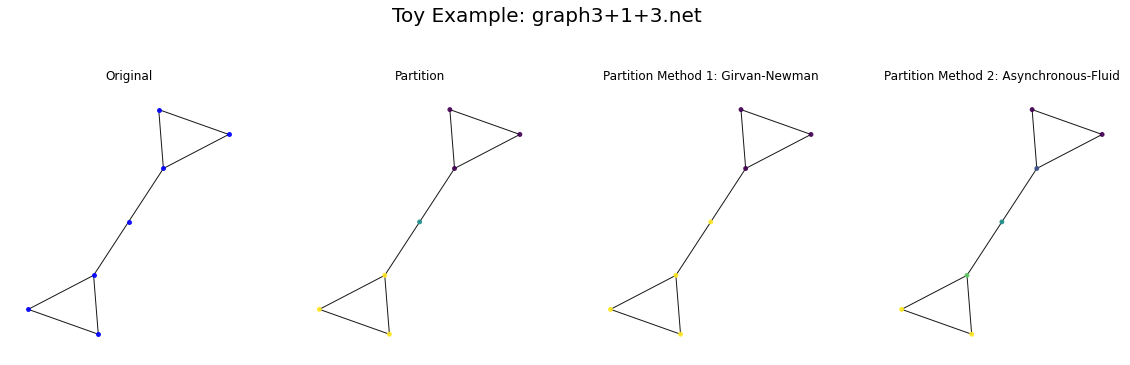

In [7]:
## load the net and clu files
g = nx.read_pajek(net)
cl = dict(read_clu(clu))

## plotting 
## set up a figure with: Original, Partition, Partition Method 1, Partition Method 2, .... Partition Method N
NUM_PARTITIONS = 4
TOTAL_FILES = sum([len(x) for _,x in DATA.items()])

## create the figure 
fig, axs = plt.subplots(1, NUM_PARTITIONS, figsize=(20,5))
axs = axs.ravel()
pos = nx.kamada_kawai_layout(g)
## plot the original 
nx.draw(g,pos=pos, ax=axs[0], node_color='b', edge_color='k', node_size=15, alpha=0.9)

## plot the partition
nx.draw(g,pos=pos, ax=axs[1], node_color=list(cl.values()), node_size=15, alpha=0.9)


## plot the partition method 1: Girvan-Newman
ca1 = CommunityAlgs(g, method='girvan_newman',layout=nx.kamada_kawai_layout(g), verbosity=False)
ca1_comm, ca1_nc = ca1.algorithm
nx.draw(g,pos=pos, ax=axs[2], node_color=dict_vals_to_list(ca1_nc[0]), node_size=15, alpha=0.9)


## plot the method 2: ASYN_FLUID
ca2 = CommunityAlgs(g, method='asyn_fluid',layout=nx.kamada_kawai_layout(g), verbosity=False)
ca2_comm, ca2_nc = ca2.algorithm
nx.draw(g,pos=pos, ax=axs[3], node_color=dict_vals_to_list(ca2_nc), node_size=15, alpha=0.9)

## set the titles 
axs[0].set_title('Original')
axs[1].set_title('Partition')
axs[2].set_title('Partition Method 1: Girvan-Newman')
axs[3].set_title('Partition Method 2: Asynchronous-Fluid')
plt.suptitle(f'Toy Example: {net.split("/")[-1]}', fontsize=20, y=1.1)
plt.show()

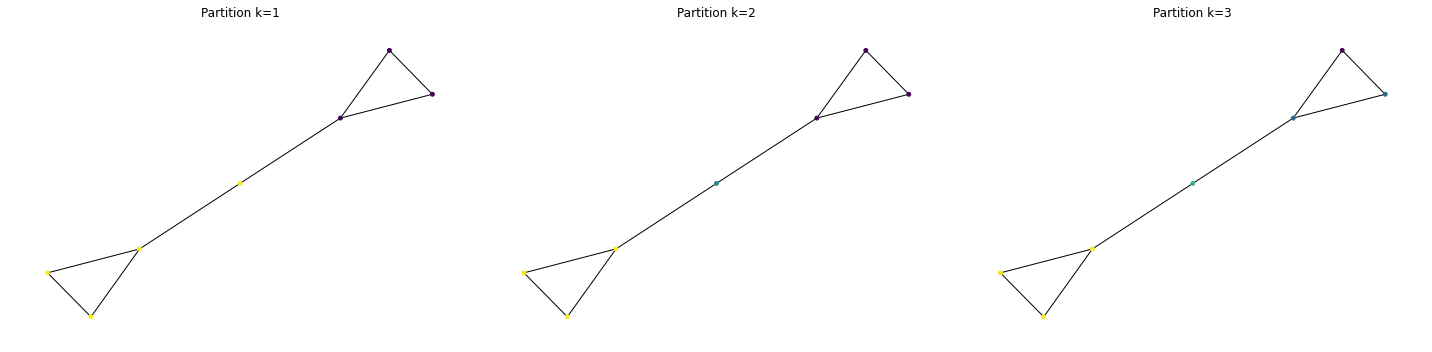

In [8]:
## This works to plot the different k-communities in a graph 
from networkx.algorithms.community.centrality import girvan_newman
mapper = {name:idx for idx, name in  enumerate(g.nodes())}
## apply the algorithm to the graph 
communities = girvan_newman(g) ## generator object
## another approach to get the community
pos = nx.fruchterman_reingold_layout(g)
import itertools 
## define the number of communities (tuple)
k = 3
fig, axs = plt.subplots(1, k, figsize=(20,5))
axs = axs.ravel()
for idx, comm in enumerate(itertools.islice(communities, k)):
    part = tuple(sorted(c) for c in comm)
    b = lol2idx(part) ## Converts the list of list into a dictionary of sublist-index 
    nx.draw(g,pos=pos, node_color=list(b.values()), node_size=15, ax=axs[idx])#,with_labels=True)
    axs[idx].set_title(f"Partition k={idx+1}")
plt.tight_layout()

In [9]:
## define a base algorithm class 
class BaseAlgorithm:
    def __init__(self, **kwargs):
        pass 
    def _get_community(self):
        pass
    def _get_node_color(self):
        if type(self._get_community()) == dict:
            return lol2idx(self._get_community())
        else: 
            return {i:idx for idx, i in enumerate(self._get_community())}

## inheritance for from the BaseAlgorithm class        
class BestPartition(BaseAlgorithm):
    def __init__(self,graph, **kwargs):
        self.graph = graph
        self.community = self._get_community()
        super().__init__(**kwargs)
        self.graph = graph
    def _get_community(self):
        return list(community_louvain.best_partition(self.graph))
    
BestPartition(g)._get_community()
BestPartition(g)._get_node_color()


{'Left1': 0,
 'Left2': 1,
 'LeftHub': 2,
 'Middle': 3,
 'RightHub': 4,
 'Right2': 5,
 'Right1': 6}

#### Code

#### Community Detection Algorithm 1: Girvan-Newman algorithm

https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.centrality.girvan_newman.html#networkx.algorithms.community.centrality.girvan_newman

- Divisive method, progressively removes edges from the original graph. 
- Removes the "most-valuable" edge. 
    - Highest betweenness centrality.
        - Highest number of shortest paths between nodes. 
        - definition is unclear but something as: 
            Number of shortest paths through V or E / Total shortest paths
- Result can be shown as a dendrogram. 

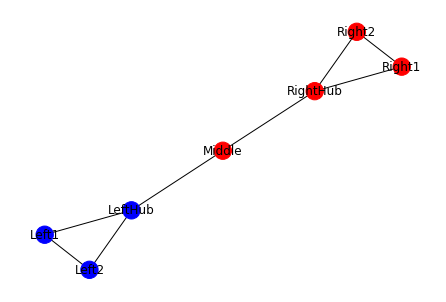

In [10]:
## apply the algorithm to the graph 
communities = girvan_newman(g) ## generator object 
## get the nodes belonging to the first community
node_groups = [com for com in next(communities)]
## loop over the nodes in the original graph 
## if they are the original assign a color to them
c1 = 'red'
c2 = 'blue'
color_map = [c2 if node in node_groups[0] else c1  for node in g.nodes()]
## draw it again 
nx.draw(g, node_color=color_map, with_labels=True)
plt.show()

In [12]:
## another approach to get the community
import itertools 
## define the number of communities (tuple)
k = 5
for comm in itertools.islice(communities, k):
    print(tuple(sorted(c) for c in comm))

(['Left1', 'Left2', 'LeftHub'], ['Middle'], ['Right1', 'Right2', 'RightHub'])
(['Left1'], ['Left2', 'LeftHub'], ['Middle'], ['Right1', 'Right2', 'RightHub'])
(['Left1'], ['Left2'], ['LeftHub'], ['Middle'], ['Right1', 'Right2', 'RightHub'])
(['Left1'], ['Left2'], ['LeftHub'], ['Middle'], ['RightHub'], ['Right1', 'Right2'])
(['Left1'], ['Left2'], ['LeftHub'], ['Middle'], ['RightHub'], ['Right2'], ['Right1'])


{'Left1': 1, 'Left2': 1, 'LeftHub': 1, 'Middle': 1, 'RightHub': 0, 'Right2': 0, 'Right1': 0}


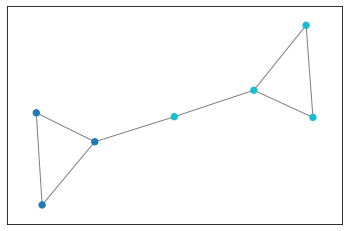

In [13]:
## using another package 
from community import community_louvain
import community
import matplotlib.cm as cm

# compute the best partition
partition = community_louvain.best_partition(g)
print(partition)
# draw the graph
pos = nx.spring_layout(g)
# color the nodes according to their partition
cmap = cm.get_cmap('tab10', max(partition.values()) + 1)
## draw the nodes
nx.draw_networkx_nodes(g, pos, partition.keys(), node_size=40,
                       cmap=cmap, node_color=list(partition.values()))
## draw the edges 
nx.draw_networkx_edges(g, pos, alpha=0.5)
plt.show()


In [14]:
## given two sets of partitions or communities, calculate the metrics
from src.helpers.metrics import compute_metrics
## community 1 
l1 = sorted(partition.values(),reverse=False)
## community 2 
l2 = [1,1,1,1,2,2,2]

#Computing the modularity
nx_comm.modularity(g, node_groups)
print(node_groups)


## compute the metrics
compute_metrics(l1,l2)

{'NMI': 0.5294617736385714,
 'Jaccard_index:': 0.07692307692307693,
 'Rand_index': 0.4166666666666667,
 'NVI': 0.27208952782101004}

In [15]:
partition = community.best_partition(g)
pos = nx.spring_layout(g)
nx.draw_networkx_nodes(g, pos, node_color=list(partition.values))
nx.draw_networkx_edges(g,pos,alpha=0.3)

TypeError: 'builtin_function_or_method' object is not iterable

#### Community Detection Algorithm 2: Fluid Communities algorithm

https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.centrality.girvan_newman.html#networkx.algorithms.community.centrality.girvan_newman


Very nice graphs 
https://arxiv.org/pdf/1703.09307.pdf

- Based on "fluids interacting with each other" 
    - expanding and pushing each other. 

Mechanics: 
- Initial k communities initialized on a random vertex. 
- Iterate over all vertices in random order. 
- **Vertex move from one place to the other, different densities, shifts**


In [107]:
## import 
from networkx.algorithms.community import asyn_fluid
## set parameters 
## K is the number of communities
K = 6
## max_iter is the maximum number of iterations
max_iter = 100
## assign fluids 
fluids = asyn_fluid.asyn_fluidc(G=g, k=K, max_iter=max_iter)
## iterate over the fluids and print the communities
cmms = [fluid for fluid in fluids]

#Modularity
modularity_fluid = nx_comm.modularity(g,cmms)
print(modularity_fluid)

l_fluid = sorted(color_map,reverse=False)


## compute the metrics
metrics_fluid = compute_metrics(l_fluid,l1)
print(metrics_fluid)



-0.0703125
{'NMI': 0.16245190513132296, 'Jaccard_index:': 0.0, 'Rand_index': -0.07692307692307693, 'NVI': 0.08348376476179487}


The modularity measure is characterized as follows (Newman, 2008): "strictly less than 1, and takes positive values if there are more edges between vertices of the same type than we would expect by chance, and negative ones if there are less"

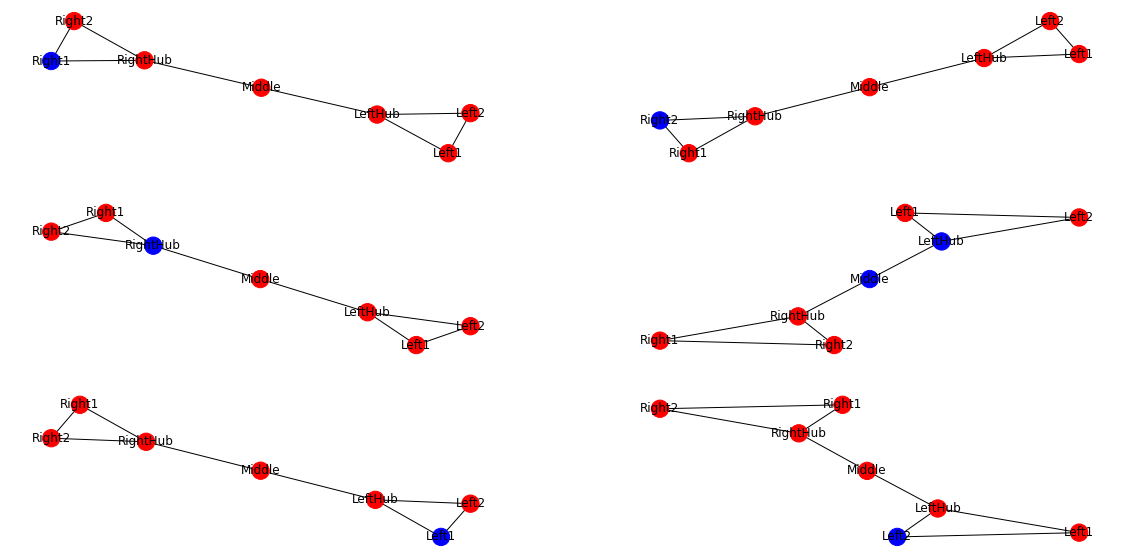

In [103]:
## plot the graph
fig, axs = plt.subplots(3,2, figsize=(20,10))
axs = axs.ravel()
## assign a color to each community
for idx, i in enumerate(cmms):
    color_map = [c2 if node in cmms[idx] else c1  for node in g.nodes()]     
    ## drawing the graph
    nx.draw(g, node_color=color_map, with_labels=True, ax=axs[idx])

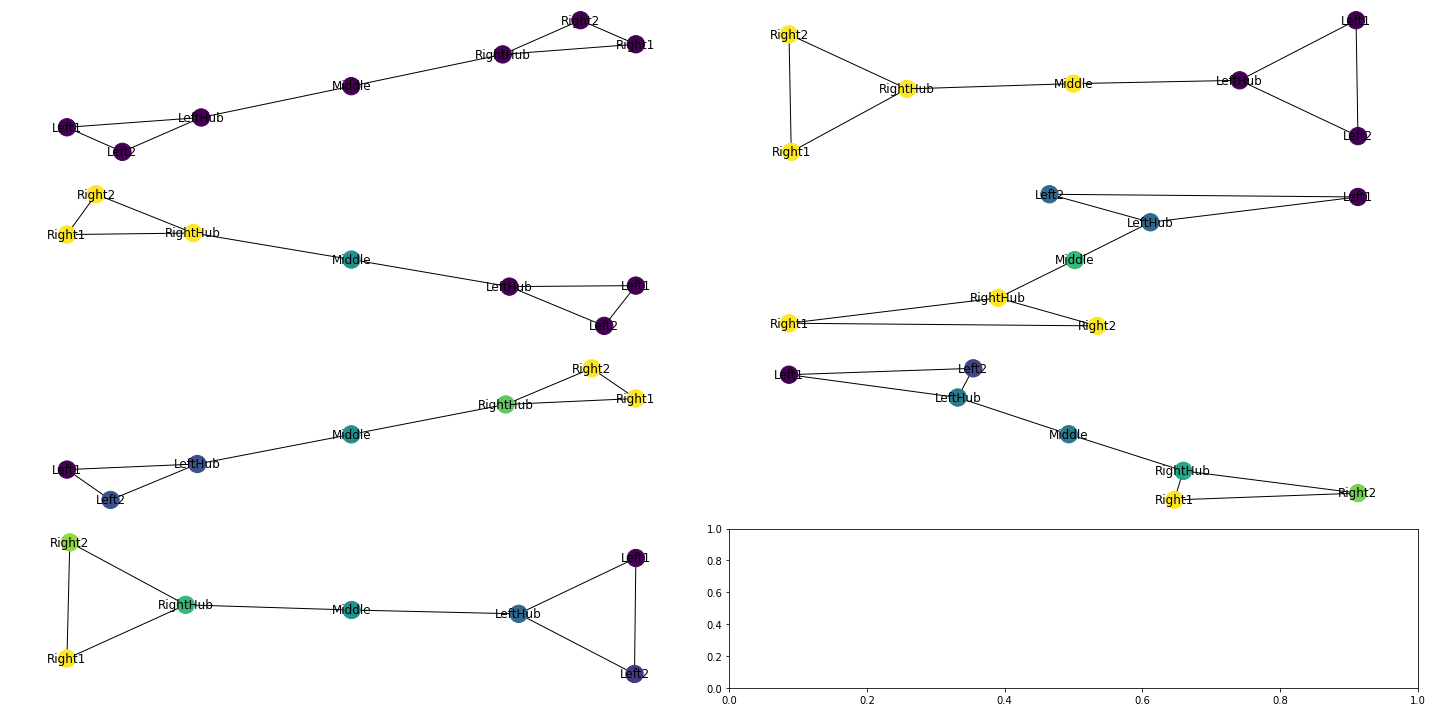

In [104]:
fig, axs = plt.subplots(4,2, figsize=(20,10))
axs = axs.ravel()
for idx, K in enumerate(range(1,len(g.edges()),1)):
    fluids = asyn_fluid.asyn_fluidc(G=g, k=K, max_iter=max_iter)
    l = [fluid for fluid in fluids]
    cy = lol2idx(l)
    cd = dict_vals_to_list(cy)
    nx.draw(g, node_color=cd, with_labels=True, ax=axs[idx])
plt.tight_layout()

#### Community Detection Algorithm 3: Label Propagation algorithm

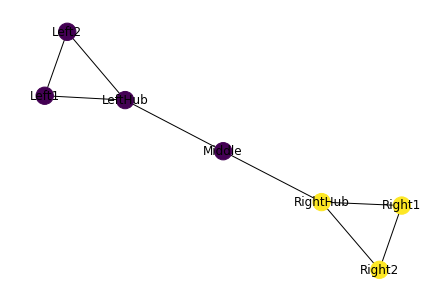

In [52]:
from networkx.algorithms.community import label_propagation
#compute the communities
communities = label_propagation.label_propagation_communities(g)
nc_propagation = lol2idx(communities)
nx.draw(g, node_color=dict_vals_to_list(nc_propagation), with_labels=True)

In [53]:
l_propagation = sorted(nc_propagation,reverse=True)

In [54]:
compute_metrics(l_propagation,l2)

{'NMI': 0.5195552060130464,
 'Jaccard_index:': 0.0,
 'Rand_index': 0.0,
 'NVI': 0.2669985591396789}

#### Community Detection Algorithm 4: Clique Percolation algorithm

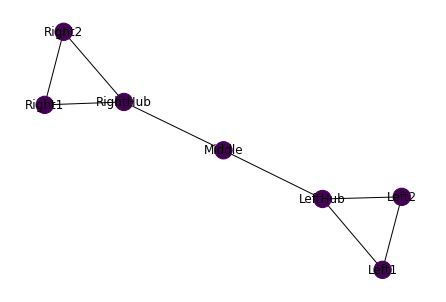

In [55]:
from networkx.algorithms.community import k_clique_communities
## define k
k = 2
comms = list(k_clique_communities(g,k))
nc_clique = lol2idx(comms)
nx.draw(g, node_color=dict_vals_to_list(nc_clique), with_labels=True)


In [57]:
l_clique = sorted(nc_clique,reverse=False)

In [58]:
## compute the metrics
compute_metrics(l_clique,l2)

{'NMI': 0.5195552060130464,
 'Jaccard_index:': 0.0,
 'Rand_index': 0.0,
 'NVI': 0.2669985591396789}